# examine stopping of iterative identification of Ly$\alpha$ absorption

In [1]:
import os
import pickle
import numpy as np

import torch

In [2]:
from spenderq import util, load_model
from spenderq import lyalpha as LyA

In [3]:
from sklearn.mixture import GaussianMixture as GMix
from scipy.stats import norm as sp_norm

In [4]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [5]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 0


/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [7]:
ibatch = 0 
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [8]:
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

In [9]:
recons = []
niter = 3
recons.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.recons.npy' % (niter, ibatch)))
recons.append(np.load('/tigress/chhahn/spender_qso/train/london.rebin.sigma2.iter%i_%i.recons.npy' % (niter, ibatch)))
recons.append(np.load('/tigress/chhahn/spender_qso/train/london.rebin.sigma1.iter%i_%i.recons.npy' % (niter, ibatch)))

recons = np.array(recons)

In [10]:
dtrue_lya, dtrue_lyb = [], [] 
drecon0_lya, drecon0_lyb = [], [] # 2 sigma
drecon1_lya, drecon1_lyb = [], [] # 1.5 sigma
drecon2_lya, drecon2_lyb = [], [] # 1 sigma

for igal in np.arange(len(spec)):                          
    w_lya = (np.array(models[0].wave_obs) < 1215. * (1.+np.array(z)[igal])) & (np.array(models[0].wave_obs) > 1026. * (1.+np.array(z)[igal]))
    w_lyb = (np.array(models[0].wave_obs) < 1026. * (1.+np.array(z)[igal]))

    true_spec = util.trapz_rebin(np.linspace(3.5e3, 1e4, 3251), np.array(true_cont[igal]/norm[igal]), 
                                 xnew=np.array(models[0].wave_obs)) - np.array(spec)[igal]
    true_spec *= np.array(w[igal])**0.5    
    
    dtrue_lya.append(true_spec[w_lya])
    dtrue_lyb.append(true_spec[w_lyb])
    
    recon_spec = util.trapz_rebin(np.array(models[0].wave_rest) * (1.+np.array(z)[igal]), np.array(recons[1][igal]),
                                  xnew=np.array(models[0].wave_obs)) - np.array(spec)[igal]
    recon_spec *= np.array(w[igal])**0.5     
    
    drecon0_lya.append(recon_spec[w_lya])
    drecon0_lyb.append(recon_spec[w_lyb])   
    
    recon_spec = util.trapz_rebin(np.array(models[0].wave_rest) * (1.+np.array(z)[igal]), np.array(recons[0][igal]),
                                  xnew=np.array(models[0].wave_obs)) - np.array(spec)[igal]
    recon_spec *= np.array(w[igal])**0.5     
    
    drecon1_lya.append(recon_spec[w_lya])
    drecon1_lyb.append(recon_spec[w_lyb])  
    
    recon_spec = util.trapz_rebin(np.array(models[0].wave_rest) * (1.+np.array(z)[igal]), np.array(recons[2][igal]),
                                  xnew=np.array(models[0].wave_obs)) - np.array(spec)[igal]
    recon_spec *= np.array(w[igal])**0.5     
    
    drecon2_lya.append(recon_spec[w_lya])
    drecon2_lyb.append(recon_spec[w_lyb])      
    
dtrue_lya = np.concatenate(dtrue_lya)
drecon0_lya = np.concatenate(drecon0_lya)
drecon1_lya = np.concatenate(drecon1_lya)
drecon2_lya = np.concatenate(drecon2_lya)

dtrue_lyb = np.concatenate(dtrue_lyb)
drecon0_lyb = np.concatenate(drecon0_lyb)
drecon1_lyb = np.concatenate(drecon1_lyb)
drecon2_lyb = np.concatenate(drecon2_lyb)

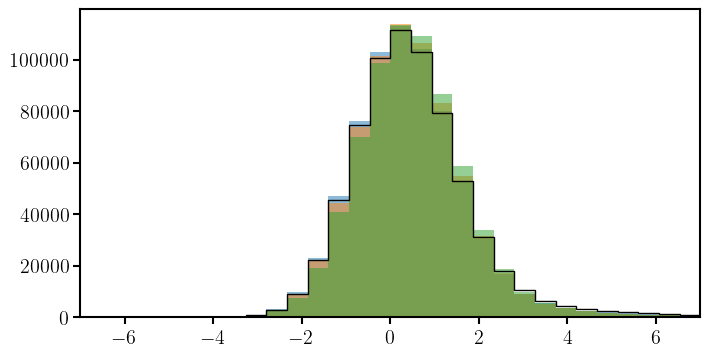

In [21]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.hist(dtrue_lya, range=(-7, 7), bins=30, histtype='step', color='k')    
sub.hist(drecon2_lya, range=(-7, 7), bins=30, alpha=0.5)
sub.hist(drecon1_lya+0.2, range=(-7, 7), bins=30, alpha=0.5)
sub.hist(drecon0_lya+0.3, range=(-7, 7), bins=30, alpha=0.5)
sub.set_xlim(-7, 7)
plt.show()

In [12]:
np.mean(dtrue_lya < 0), np.mean(dtrue_lyb < 0)

(np.float64(0.3691800410871404), np.float64(0.36298368253167995))

In [13]:
np.mean(drecon0_lya < 0), np.mean(drecon0_lyb < 0)

(np.float64(0.44962653285532606), np.float64(0.46798557314743894))

In [14]:
np.mean(drecon1_lya < 0), np.mean(drecon1_lyb < 0)

(np.float64(0.43643289963574006), np.float64(0.4509506403854917))

In [15]:
np.mean(drecon2_lya < 0), np.mean(drecon2_lyb < 0)

(np.float64(0.37918280324784065), np.float64(0.3970535480555744))

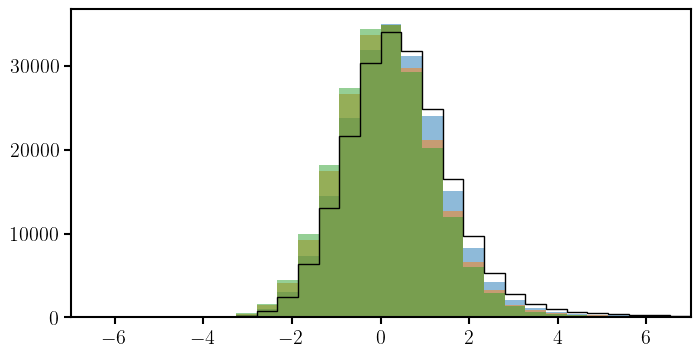

In [23]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.hist(dtrue_lyb, range=(-7, 7), bins=30, histtype='step', color='k')    
sub.hist(drecon2_lyb, range=(-7, 7), bins=30, alpha=0.5)
sub.hist(drecon1_lyb, range=(-7, 7), bins=30, alpha=0.5)
sub.hist(drecon0_lyb, range=(-7, 7), bins=30, alpha=0.5)
sub.set_xlim(-7, 7)
plt.show()

[0.01619625 1.22918449 7.83984697]
[0.9369407  1.2953616  9.05204917]
[0.67788511 0.30105808 0.02105681]

[-0.20038079  1.02010638  7.06007861]
[0.92319861 1.18324537 8.78711514]
[0.64823752 0.33002644 0.02173605]

[-0.3162689   0.96176204  5.64579179]
[0.89360881 1.053682   7.06639991]
[0.61099771 0.36152228 0.02748001]



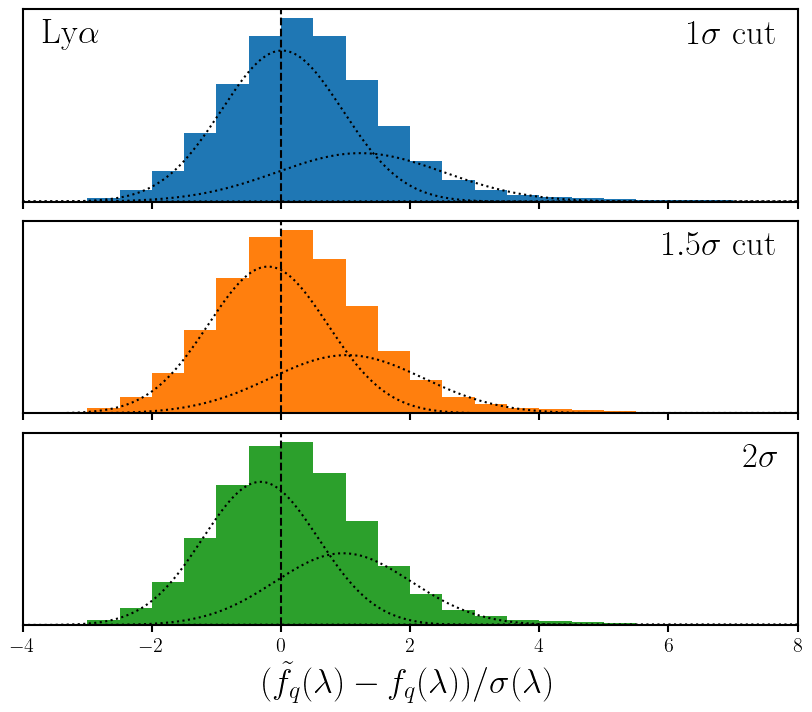

In [20]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(311)
h = sub.hist(drecon2_lya, range=(-10, 10), bins=40, color='C0')

_x = np.linspace(-10, 10, 10000)
# plot best-fit GMM
gmm = GMix(n_components=3)
gmm.fit(drecon2_lya.reshape(-1, 1))
isort = np.argsort(gmm.means_.flatten())
print(gmm.means_.flatten()[isort])
print((gmm.covariances_.flatten()**0.5)[isort])
print(gmm.weights_[isort])
print()
for _i in range(3):
    _gauss = sp_norm.pdf(_x, gmm.means_.flatten()[_i], (gmm.covariances_.flatten()**0.5)[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm.weights_[_i] * _gauss, c='k', ls=':')
sub.axvline(0., color='k', linestyle='--')
sub.text(0.025, 0.95, r'Ly$\alpha$', transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.text(0.975, 0.95, r'$1\sigma$ cut', transform=sub.transAxes, ha='right', va='top', fontsize=25)
sub.set_xlim(-4, 8)
sub.set_xticklabels([])
sub.set_yticks([])

sub = fig.add_subplot(312)
h = sub.hist(drecon1_lya, range=(-10, 10), bins=40, color='C1')
gmm = GMix(n_components=3)
gmm.fit(drecon1_lya.reshape(-1, 1))
isort = np.argsort(gmm.means_.flatten())
print(gmm.means_.flatten()[isort])
print((gmm.covariances_.flatten()**0.5)[isort])
print(gmm.weights_[isort])
print()
for _i in range(3):
    _gauss = sp_norm.pdf(_x, gmm.means_.flatten()[_i], (gmm.covariances_.flatten()**0.5)[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm.weights_[_i] * _gauss, c='k', ls=':')
sub.axvline(0., color='k', linestyle='--')
sub.text(0.975, 0.95, r'$1.5\sigma$ cut', transform=sub.transAxes, ha='right', va='top', fontsize=25)
sub.set_xlim(-4, 8)
sub.set_xticklabels([])
sub.set_yticks([])

sub = fig.add_subplot(313)
h = sub.hist(drecon0_lya, range=(-10, 10), bins=40, color='C2')

gmm = GMix(n_components=3)
gmm.fit(drecon0_lya.reshape(-1, 1))
isort = np.argsort(gmm.means_.flatten())
print(gmm.means_.flatten()[isort])
print((gmm.covariances_.flatten()**0.5)[isort])
print(gmm.weights_[isort])
print()
for _i in range(3):
    _gauss = sp_norm.pdf(_x, gmm.means_.flatten()[_i], (gmm.covariances_.flatten()**0.5)[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm.weights_[_i] * _gauss, c='k', ls=':')
sub.axvline(0., color='k', linestyle='--')
sub.text(0.975, 0.95, r'$2\sigma$', transform=sub.transAxes, ha='right', va='top', fontsize=25)
sub.set_xlabel(r'$(\tilde{f}_q(\lambda) - f_q(\lambda))/\sigma(\lambda)$', fontsize=25)
sub.set_xlim(-4, 8)
sub.set_yticks([])
fig.subplots_adjust(hspace=0.1)

[-0.2845154   1.02299935  4.89952809]
[0.84443552 0.90816841 5.10337151]
[0.54999473 0.42567944 0.02432583]
[-0.45955506  0.84502867  4.45801106]
[0.83384047 0.88235737 4.96236442]
[0.53452709 0.44273923 0.02273368]
[-0.5097966   0.78695367  3.95297103]
[0.82938902 0.86543092 4.72009623]
[0.53110025 0.4465091  0.02239066]


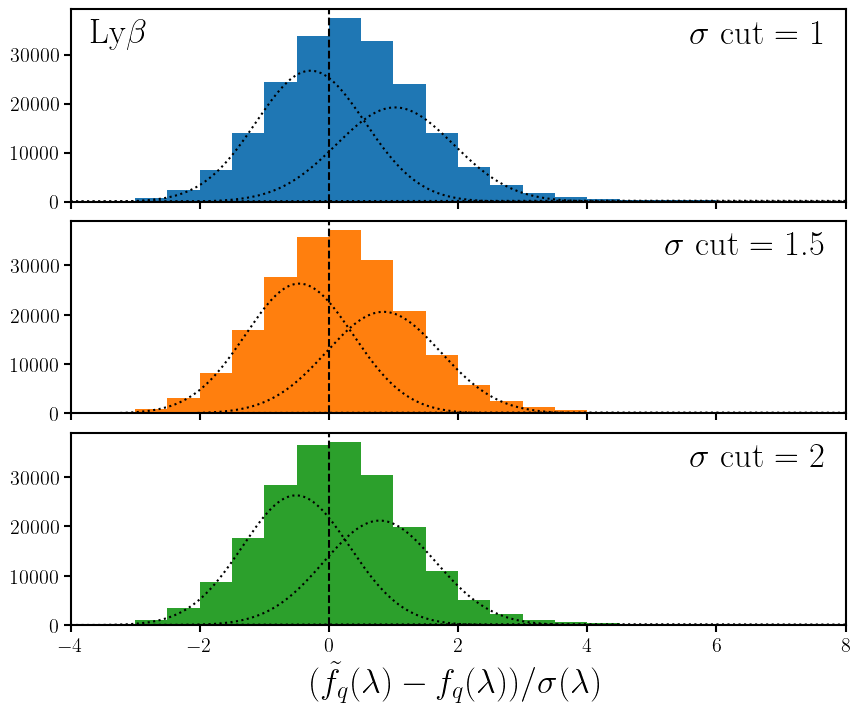

In [18]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(311)
h = sub.hist(drecon2_lyb, range=(-10, 10), bins=40, color='C0')

_x = np.linspace(-10, 10, 10000)
# plot best-fit GMM
gmm = GMix(n_components=3)
gmm.fit(drecon2_lyb.reshape(-1, 1))
isort = np.argsort(gmm.means_.flatten())
print(gmm.means_.flatten()[isort])
print((gmm.covariances_.flatten()**0.5)[isort])
print(gmm.weights_[isort])
for _i in range(3):
    _gauss = sp_norm.pdf(_x, gmm.means_.flatten()[_i], (gmm.covariances_.flatten()**0.5)[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm.weights_[_i] * _gauss, c='k', ls=':')
sub.axvline(0., color='k', linestyle='--')
sub.text(0.025, 0.95, r'Ly$\beta$', transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.text(0.975, 0.95, r'$\sigma$ cut = 1', transform=sub.transAxes, ha='right', va='top', fontsize=25)
sub.set_xlim(-4, 8)
sub.set_xticklabels([])

sub = fig.add_subplot(312)
h = sub.hist(drecon1_lyb, range=(-10, 10), bins=40, color='C1')
gmm = GMix(n_components=3)
gmm.fit(drecon1_lyb.reshape(-1, 1))
isort = np.argsort(gmm.means_.flatten())
print(gmm.means_.flatten()[isort])
print((gmm.covariances_.flatten()**0.5)[isort])
print(gmm.weights_[isort])
for _i in range(3):
    _gauss = sp_norm.pdf(_x, gmm.means_.flatten()[_i], (gmm.covariances_.flatten()**0.5)[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm.weights_[_i] * _gauss, c='k', ls=':')
sub.axvline(0., color='k', linestyle='--')
sub.text(0.975, 0.95, r'$\sigma$ cut = 1.5', transform=sub.transAxes, ha='right', va='top', fontsize=25)
sub.set_xlim(-4, 8)
sub.set_xticklabels([])

sub = fig.add_subplot(313)
h = sub.hist(drecon0_lyb, range=(-10, 10), bins=40, color='C2')

gmm = GMix(n_components=3)
gmm.fit(drecon0_lyb.reshape(-1, 1))
isort = np.argsort(gmm.means_.flatten())
print(gmm.means_.flatten()[isort])
print((gmm.covariances_.flatten()**0.5)[isort])
print(gmm.weights_[isort])
for _i in range(3):
    _gauss = sp_norm.pdf(_x, gmm.means_.flatten()[_i], (gmm.covariances_.flatten()**0.5)[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm.weights_[_i] * _gauss, c='k', ls=':')
sub.axvline(0., color='k', linestyle='--')
sub.text(0.975, 0.95, r'$\sigma$ cut = 2', transform=sub.transAxes, ha='right', va='top', fontsize=25)
sub.set_xlabel(r'$(\tilde{f}_q(\lambda) - f_q(\lambda))/\sigma(\lambda)$', fontsize=25)
sub.set_xlim(-4, 8)
fig.subplots_adjust(hspace=0.1)

bic [2415015.56447906 2405058.46341159]
aic [2414923.94989899 2404932.493364  ]
[ 0.04003354  5.76358607  1.28027862 26.45885024]
[ 0.94671871  3.84293007  1.26106548 20.03171095]
[0.68316292 0.03182682 0.28207329 0.00293697]


(-4.0, 8.0)

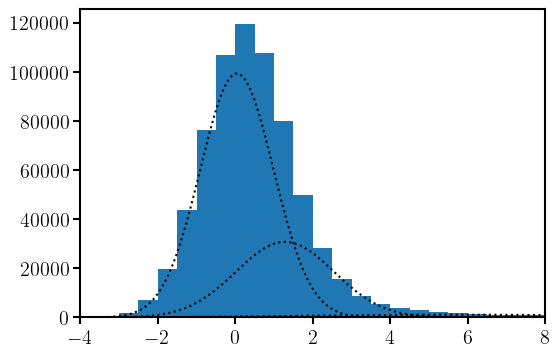

In [146]:
# fit a Gaussian mixture model to reconstruction
gmms, bics, aics = [], [], []
for i_n, n in enumerate(np.arange(3,5)): 
    gmm = GMix(n_components=n)
    gmm.fit(dtrue_lya.reshape(-1, 1))
    bics.append(gmm.bic(dtrue_lya.reshape(-1, 1))) # bayesian information criteria
    aics.append(gmm.aic(dtrue_lya.reshape(-1, 1))) # bayesian information criteria
    gmms.append(gmm)    
print('bic', np.array(bics))
print('aic', np.array(aics))
i_best = np.array(aics).argmin()
ncomp = np.arange(3,5)[i_best]

gmm_means = gmms[i_best].means_.flatten()
gmm_sigmas = gmms[i_best].covariances_.flatten()**0.5
gmm_weights = gmms[i_best].weights_
print(gmm_means)
print(gmm_sigmas)
print(gmm_weights)

fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
h = sub.hist(dtrue_lya, range=(-10, 10), bins=40)

# plot best-fit GMM
_x = np.linspace(-10, 10, 10000)
for _i in range(ncomp):
    _gauss = sp_norm.pdf(_x, gmm_means[_i], gmm_sigmas[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm_weights[_i] * _gauss, c='k', ls=':')
sub.set_xlim(-4, 8)

bic [682004.86142987 680538.5131952 ]
aic [681922.96543432 680425.90620132]
[ 0.7701022   2.1662218   6.63482677 -0.50229496]
[0.69642483 1.09177128 5.84308547 0.75056272]
[0.47063513 0.11752245 0.01804775 0.39379467]


(-10.0, 10.0)

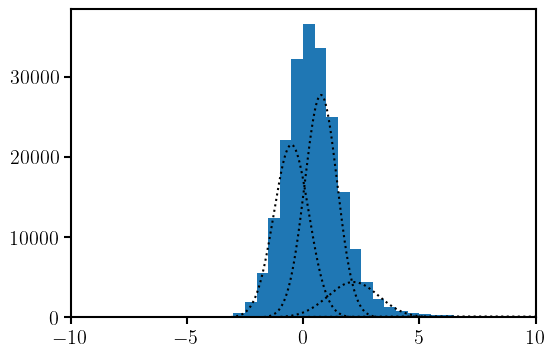

In [152]:
# fit a Gaussian mixture model to reconstruction
gmms, bics, aics = [], [], []
for i_n, n in enumerate(np.arange(3,5)): 
    gmm = GMix(n_components=n)
    gmm.fit(dtrue_lyb.reshape(-1, 1))
    bics.append(gmm.bic(dtrue_lyb.reshape(-1, 1))) # bayesian information criteria
    aics.append(gmm.aic(dtrue_lyb.reshape(-1, 1))) # bayesian information criteria
    gmms.append(gmm)    
print('bic', np.array(bics))
print('aic', np.array(aics))
i_best = np.array(aics).argmin()
ncomp = np.arange(3,5)[i_best]

gmm_means = gmms[i_best].means_.flatten()
gmm_sigmas = gmms[i_best].covariances_.flatten()**0.5
gmm_weights = gmms[i_best].weights_
print(gmm_means)
print(gmm_sigmas)
print(gmm_weights)

fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
h = sub.hist(dtrue_lyb, range=(-10, 10), bins=40)

# plot best-fit GMM
_x = np.linspace(-10, 10, 10000)
for _i in range(ncomp):
    _gauss = sp_norm.pdf(_x, gmm_means[_i], gmm_sigmas[_i])
    sub.plot(_x, np.sum(h[0] * np.diff(h[1])) * gmm_weights[_i] * _gauss, c='k', ls=':')
sub.set_xlim(-10, 10)